## In this notebook we use incident data from 2003-2017 to predict weekly incident volumes in 2018.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

import fbprophet
from fbprophet import Prophet

from fbprophet.plot  import plot_plotly
import plotly.offline as py
py.init_notebook_mode()


from fbprophet.diagnostics import cross_validation

from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import warnings
warnings.filterwarnings('ignore')

## Preparing the Incidents Dataset
The following three cell blocks are from "ExploratoryDataAnalysis_Incidents" file. For Notes and Descriptions refer to that file.

In [2]:
incidents = pd.read_csv('../data/sf-police-calls-for-service-and-incidents/police-department-incidents.csv') 
incidents = incidents.dropna()
incidents['Date Time'] = pd.to_datetime(pd.to_datetime(incidents['Date']).dt.date.astype(str) + ' ' + incidents['Time'])
incidents.drop(['Date','Time'], axis = 1, inplace = True)
unique_incidents = incidents.groupby(['IncidntNum', 'Date Time',
                                                     'Category','DayOfWeek','X','Y','Resolution'])['PdId'].count().sort_values(ascending = False).reset_index()
unique_incidents.rename(columns = {'PdId':'Count'}, inplace = True)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
Main_Categories_dict = {'Drug-related Incidents':['DRUG/NARCOTIC'],
                       'Alchohol-related Incidents':['LIQUOR LAWS', 'DRUNKENNESS', 'DRIVING UNDER THE INFLUENCE'],
                       'Property-related Incidents':['VEHICLE THEFT', 'ROBBERY', 'LARCENY/THEFT', 'VANDALISM',
                                                     'STOLEN PROPERTY','BURGLARY', 'ARSON','RECOVERED VEHICLE'],
                       'Sexual-related Incidents':['PROSTITUTION','SEX OFFENSES, FORCIBLE', 'PORNOGRAPHY/OBSCENE MAT',
                                                   'SEX OFFENSES, NON FORCIBLE'],
                       'Other Violent Incidents':['ASSAULT', 'KIDNAPPING', 'WEAPON LAWS','SUICIDE'],
                       'Other Non-Violent Incidents':['NON-CRIMINAL', 'OTHER OFFENSES', 'WARRANTS', 
                                                      'SECONDARY CODES', 'SUSPICIOUS OCC', 'FRAUD', 
                                                      'TRESPASS', 'FAMILY OFFENSES', 'MISSING PERSON', 
                                                      'RUNAWAY', 'DISORDERLY CONDUCT', 'FORGERY/COUNTERFEITING', 
                                                      'GAMBLING', 'BRIBERY', 'EXTORTION', 'EMBEZZLEMENT', 
                                                      'BAD CHECKS', 'LOITERING', 'TREA']}

In [4]:
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Drug-related Incidents']),'Main_Category'] = 'Drug-related Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Alchohol-related Incidents']),'Main_Category'] = 'Alchohol-related Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Property-related Incidents']),'Main_Category'] = 'Property-related Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Sexual-related Incidents']),'Main_Category'] = 'Sexual-related Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Other Violent Incidents']),'Main_Category'] = 'Other Violent Incidents'
unique_incidents.loc[unique_incidents['Category'].isin(Main_Categories_dict['Other Non-Violent Incidents']),'Main_Category'] = 'Other Non-Violent Incidents'


## Creating Weekly Timeseries of Incidents By Category
The Incidents dataset ranges from 2003-01-01 to 2018-05-15. Since we want to predict weekly incident volume for each incident category in 2018, we will use weekly data from 2003 to 2017 for training and 2018 data for test. We will use Prophet's built-in cross-validation function for model diagnostics. 

### Weekly Incidents Timeseries Preparation
In this function we:
- extract data related to the incident category of interest
- group the timeseries into weekly data
- rename the columns to be compatible with fbprophet requirements
- divide the dataset into train and test

In [5]:
def Weekly_data_prep (unique_incidents , cat , train_start , 
                      train_end , test_start ,
                      test_end ):
    
    unique_incidents_sub = unique_incidents.loc[unique_incidents['Main_Category'] == cat]
    unique_incidents_sub.index = pd.to_datetime(unique_incidents_sub['Date Time'])
    unique_incidents_sub_weekly = unique_incidents_sub.groupby(pd.Grouper(freq = 'W'))['IncidntNum'].count().to_frame().rename(columns = {'IncidntNum':'y'})

    unique_incidents_sub_weekly['ds'] = unique_incidents_sub_weekly.index

    #### Limiting the training dataset into complete weeks
    unique_incidents_sub_weekly_train = unique_incidents_sub_weekly[train_start:train_end]
    unique_incidents_sub_weekly_test = unique_incidents_sub_weekly[test_start:test_end]

    unique_incidents_sub_weekly_train.index = np.arange(len(unique_incidents_sub_weekly_train))
    unique_incidents_sub_weekly_test.index = np.arange(len(unique_incidents_sub_weekly_test))
    
    return [unique_incidents_sub_weekly_train , unique_incidents_sub_weekly_test]

    

In [6]:
def Plot_Timeseries (df_train , df_test , title, savepath):
    fig = plt.figure(figsize = (20,10))
    ax = fig.add_subplot(1,1,1)
    plt.plot(df_train['ds'] , df_train['y'] , ls = '', marker = 'o' , color = 'blue' , markersize = 5, label = 'training')
    plt.plot(df_test['ds'] , df_test['y'] , ls = '', marker = 'o' , color = 'red' , markersize = 5, label = 'test')
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.xlabel('Time', fontsize = 18)
    plt.ylabel('Weekly Number of Incidents', fontsize = 18)
    plt.title (title, fontsize = 24)
    plt.legend(fontsize = 22)
    plt.savefig (savepath,bbox_inches = 'tight')

In [7]:
def Weekly_Incident_Model (unique_incidents , cat , train_start , train_end , test_start , test_end):
    
    
    ### creating weekly timeseries for train and test datasets
    [unique_incidents_weekly_train , 
    unique_incidents_weekly_test] = Weekly_data_prep (unique_incidents , cat , train_start = train_start, 
                          train_end = train_end, test_start = test_start,
                          test_end = test_end)
    
    ### plotting timeseries
    savepath = '../plots/model/'+cat+'/weekly_ts_'+cat+'.pdf'
    Plot_Timeseries (unique_incidents_weekly_train , unique_incidents_weekly_test, 'Weekly Time Series of '+ cat, savepath) 
    
    
    
    ### Initializing and Training the Prophet Model on Training Dataset
    m = Prophet(interval_width = 0.95, changepoint_prior_scale=2)
    m.fit(unique_incidents_weekly_train)   
    
    
    ### creating test timeseries for prediction
    future = m.make_future_dataframe(periods = 365, freq = 'W')
    future = future.loc[(future['ds']>= train_start)&(future['ds']<test_end)]

    forecast = m.predict(future)
    forecast_out = forecast[['ds','yhat','yhat_lower','yhat_upper']]
    
    
    
    ### Plotting forecasts
    fig = plt.figure(figsize = (20,6))
    m.plot(forecast)
    plt.plot(unique_incidents_weekly_test['ds'],
             unique_incidents_weekly_test['y'] , ls = '',marker = 'o',color = 'red',markersize = 3,alpha = 0.5)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xlabel('Time', fontsize = 18)
    plt.ylabel('Weekly Number of Incidents', fontsize = 18)
    plt.savefig ('../plots/model/'+cat+'/forecast_'+cat+'_full_TS.pdf',bbox_inches = 'tight')



    ### Plotting forecasts zoomed in for 2017-2018
    fig = plt.figure(figsize = (20,6))
    m.plot(forecast)
    plt.plot(unique_incidents_weekly_test['ds'],
             unique_incidents_weekly_test['y'] , ls = '',marker = 'o',color = 'red',markersize = 3,alpha = 0.5)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xlabel('Time', fontsize = 18)
    plt.ylabel('Weekly Number of Incidents', fontsize = 18)
    plt.xlim(pd.to_datetime('2017-01-01'),pd.to_datetime('2018-05-31'))
    plt.savefig ('../plots/model/'+cat+'/forecast_'+cat+'_zoom_TS.pdf',bbox_inches = 'tight')
    
    

    ### Plotting Model Components (Trend and Seasonality)
    fig = m.plot_components(forecast)
    plt.savefig ('../plots/model/'+cat+'/forecast_components_'+cat+'_zoom_TS.pdf',bbox_inches = 'tight')
    
    

    ### Model Diagnostics (using prophet's built-in cross validation to validate the model performance)
    df_cv = cross_validation(m, initial='365 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    for met in ['rmse' , 'mae' , 'mse' , 'mape']:
        fig = plot_cross_validation_metric(df_cv, metric=met)
        plt.savefig ('../plots/model/'+cat+'/forecast_'+cat+'_diagnostic_'+met+'.pdf',bbox_inches = 'tight')
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2004-03-09 00:00:00 and 2016-12-31 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2004-03-09 00:00:00 and 2016-12-31 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2004-03-09 00:00:00 and 2016-12-31 00:00:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

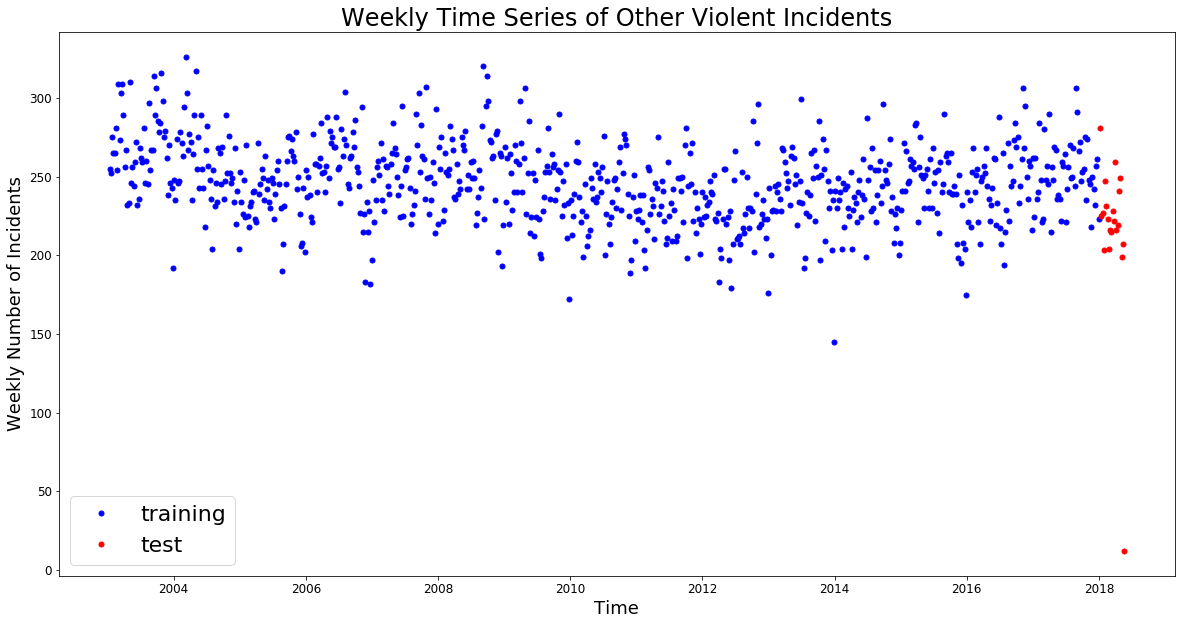

<Figure size 1440x432 with 0 Axes>

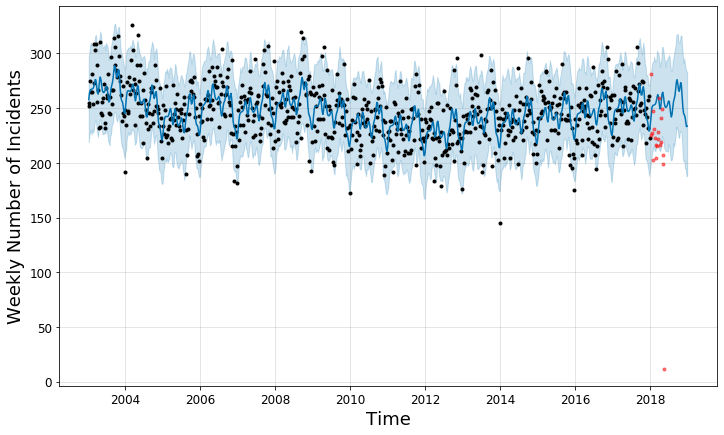

<Figure size 1440x432 with 0 Axes>

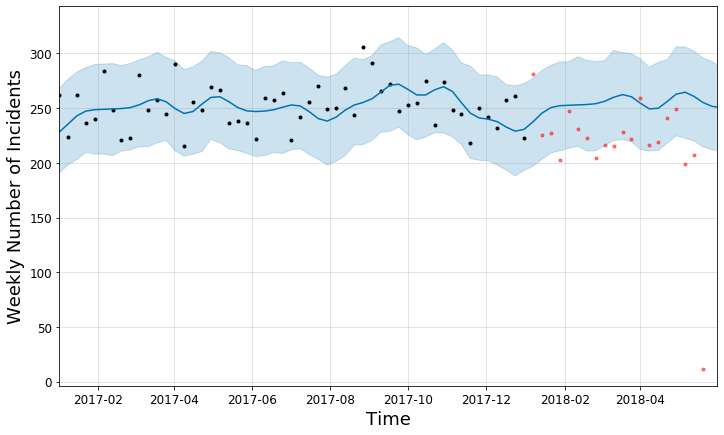

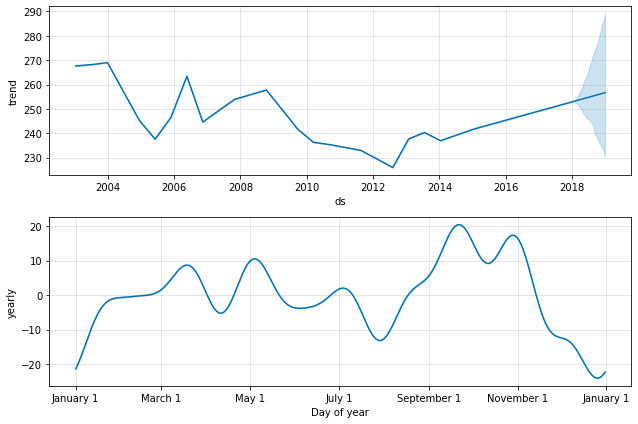

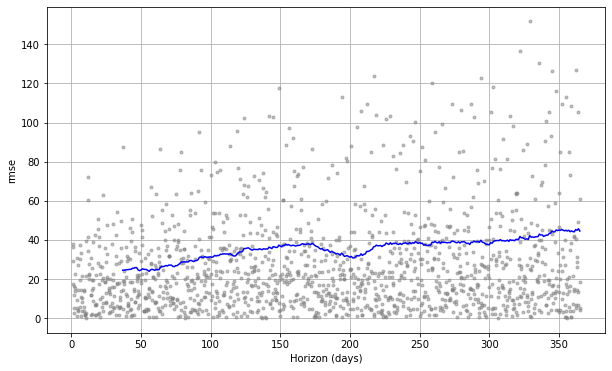

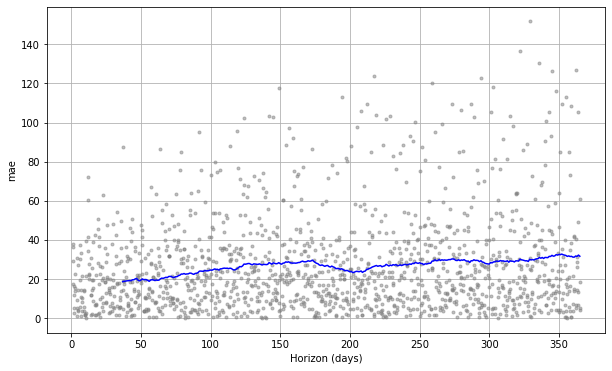

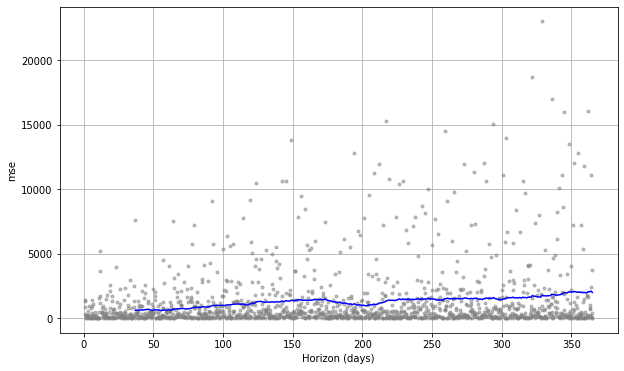

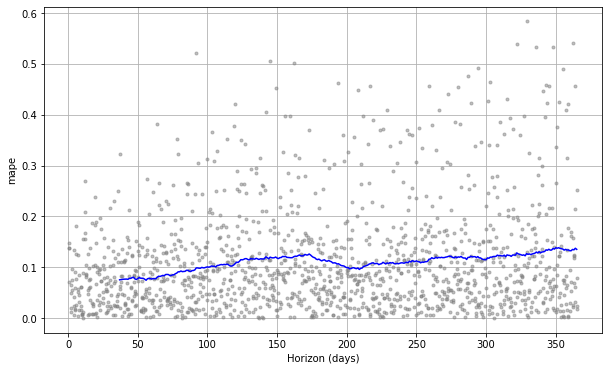

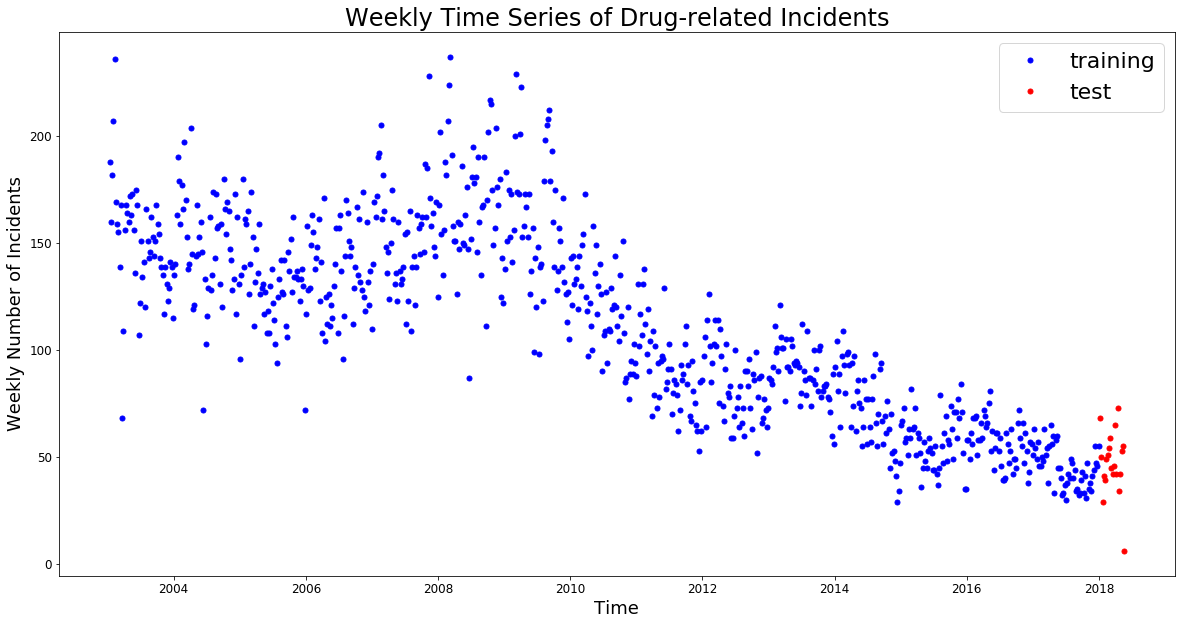

<Figure size 1440x432 with 0 Axes>

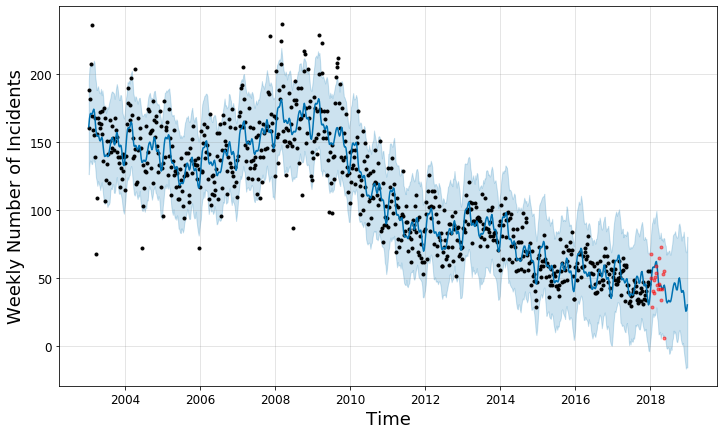

<Figure size 1440x432 with 0 Axes>

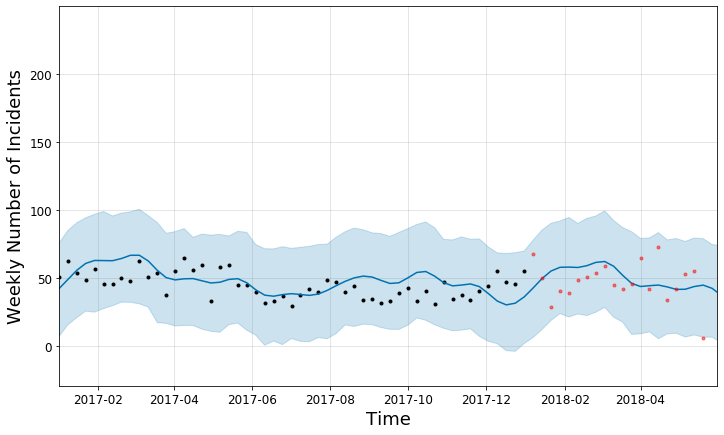

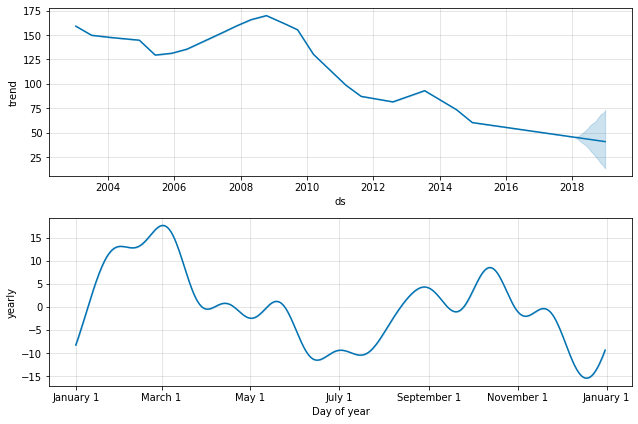

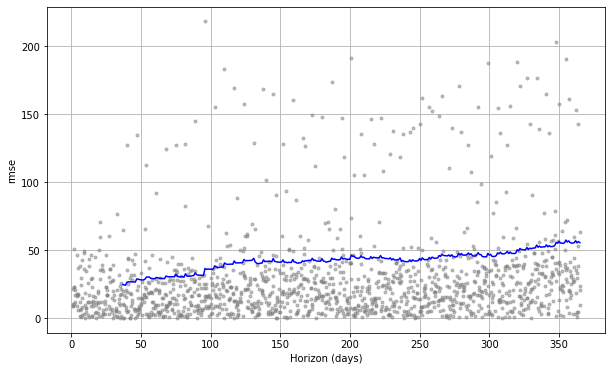

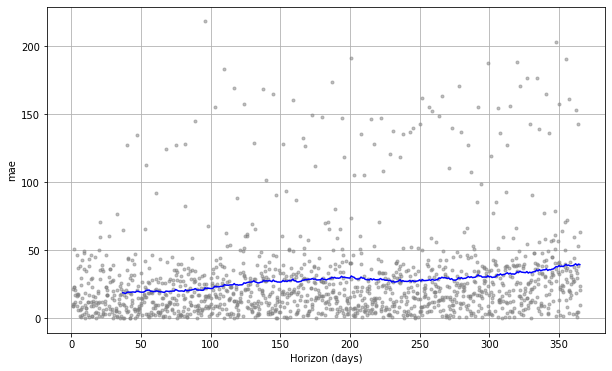

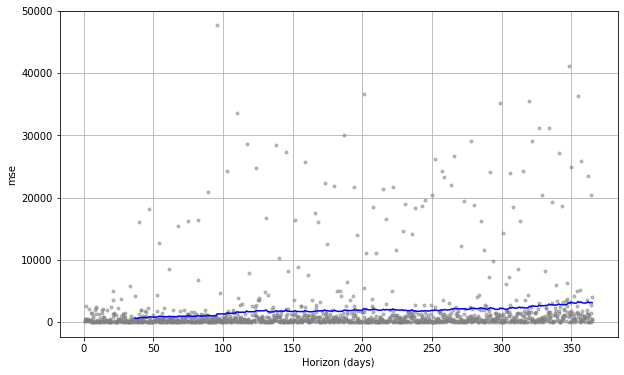

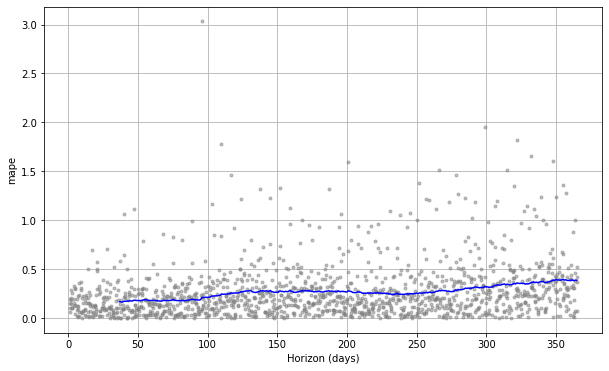

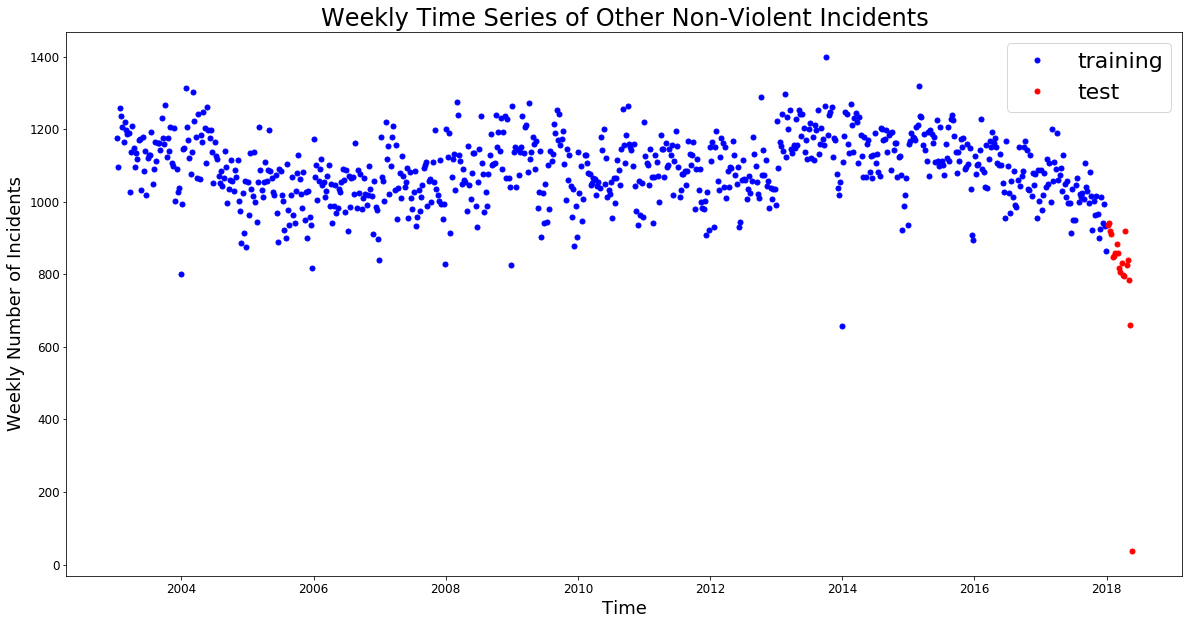

<Figure size 1440x432 with 0 Axes>

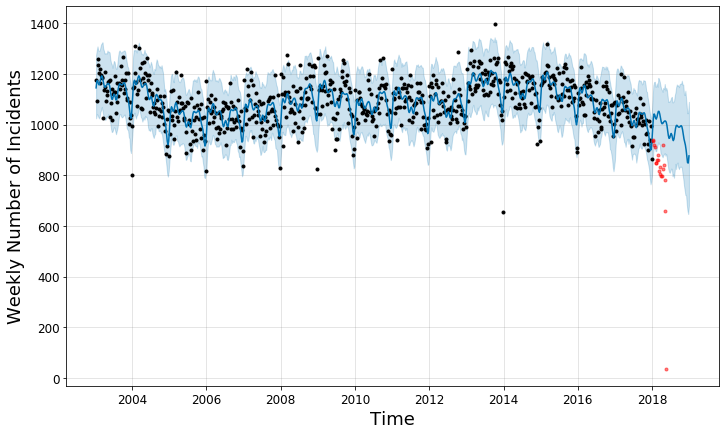

<Figure size 1440x432 with 0 Axes>

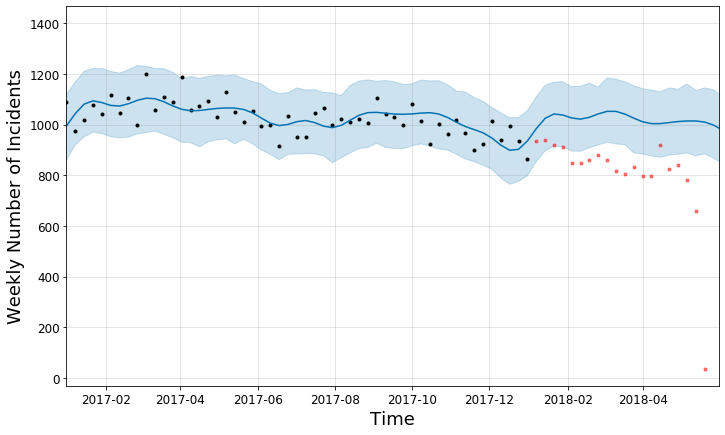

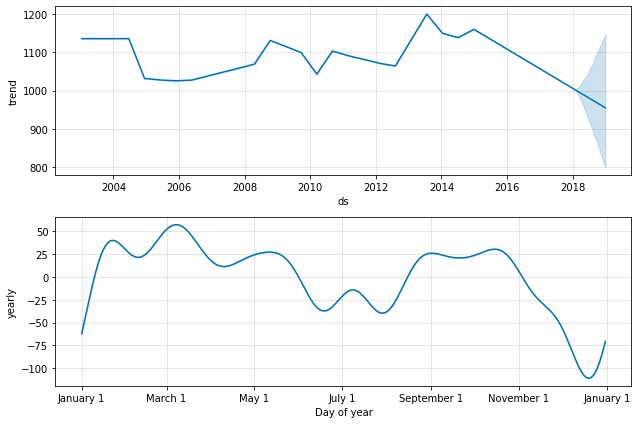

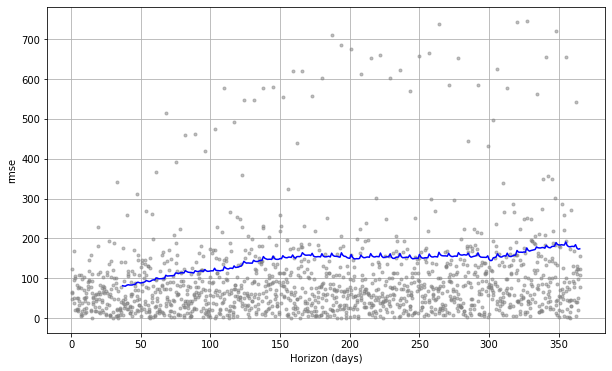

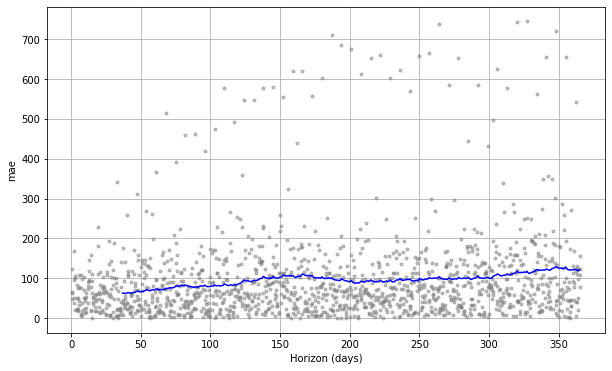

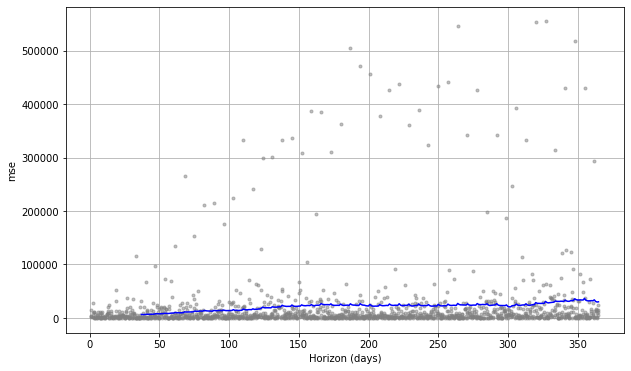

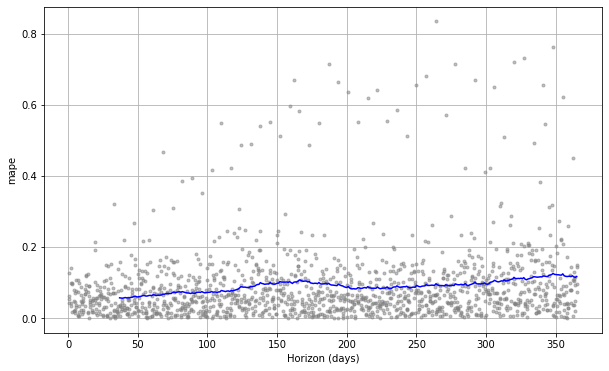

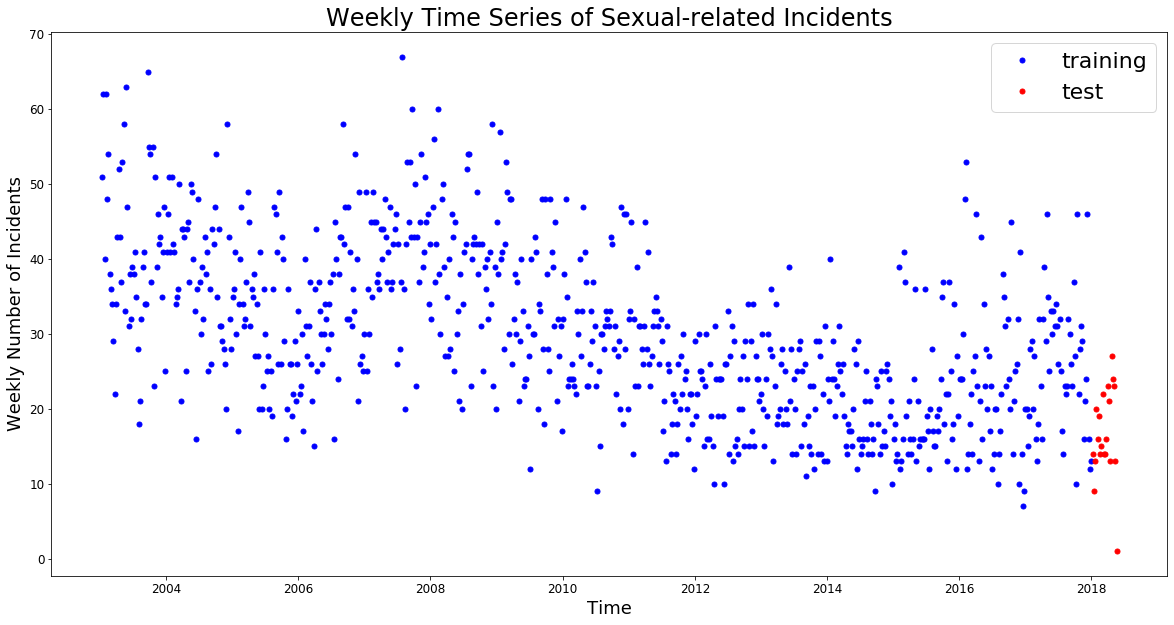

<Figure size 1440x432 with 0 Axes>

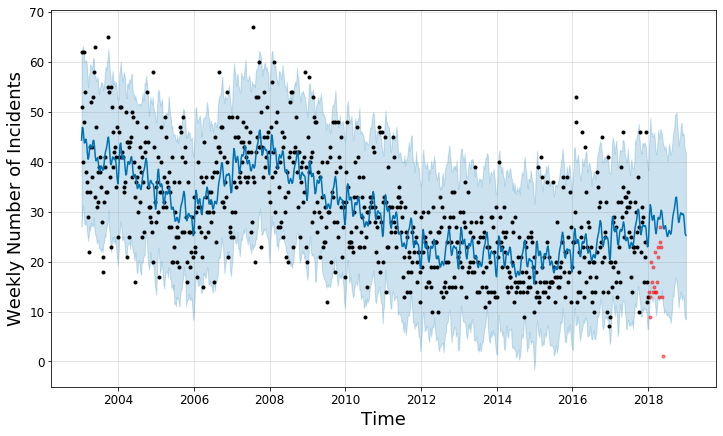

<Figure size 1440x432 with 0 Axes>

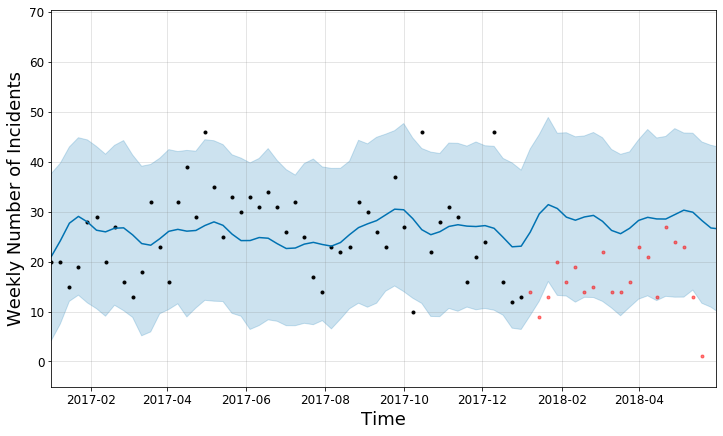

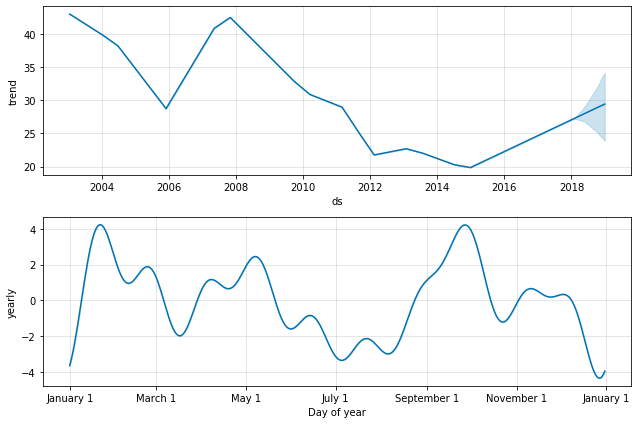

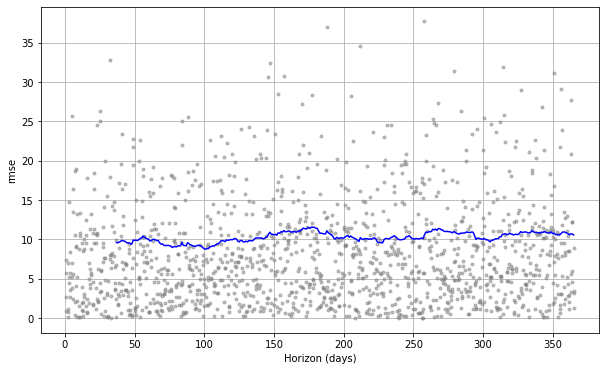

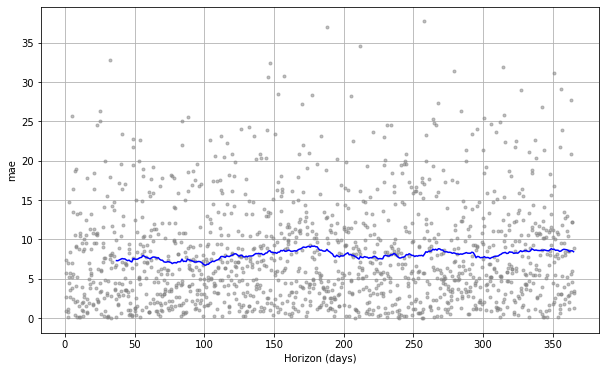

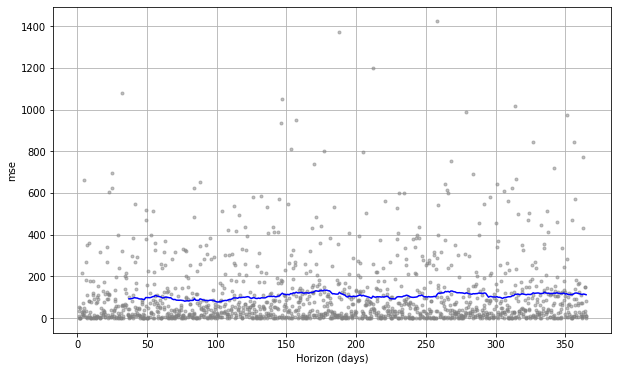

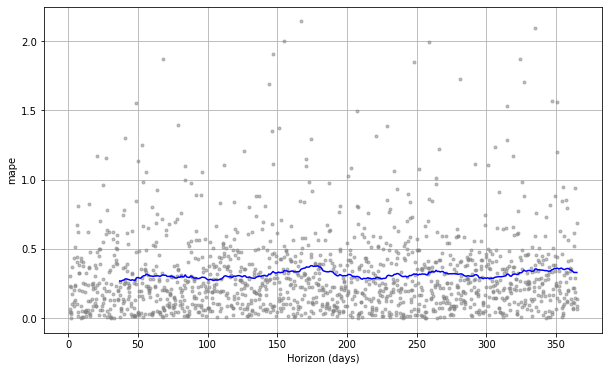

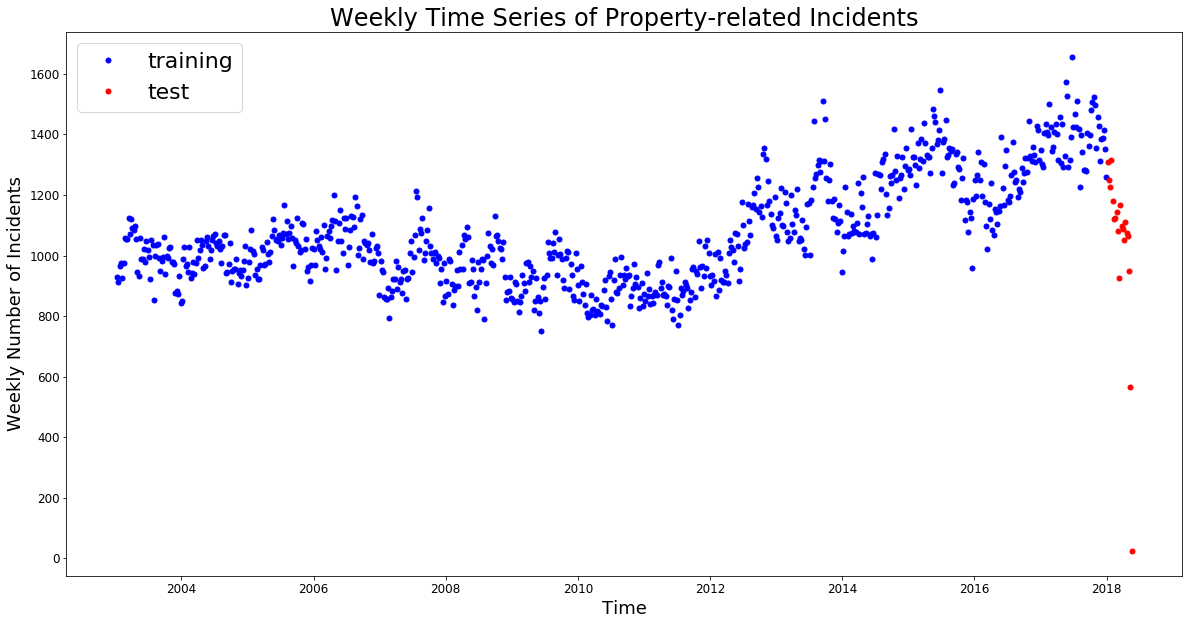

<Figure size 1440x432 with 0 Axes>

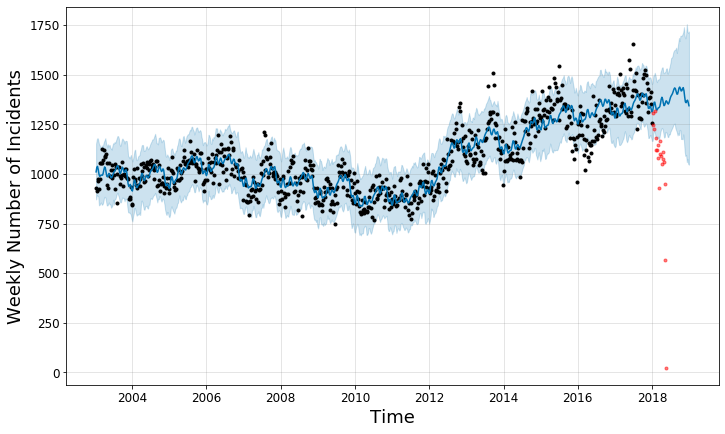

<Figure size 1440x432 with 0 Axes>

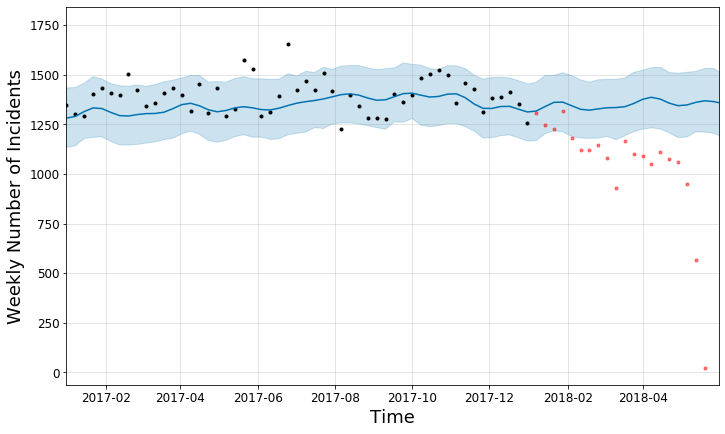

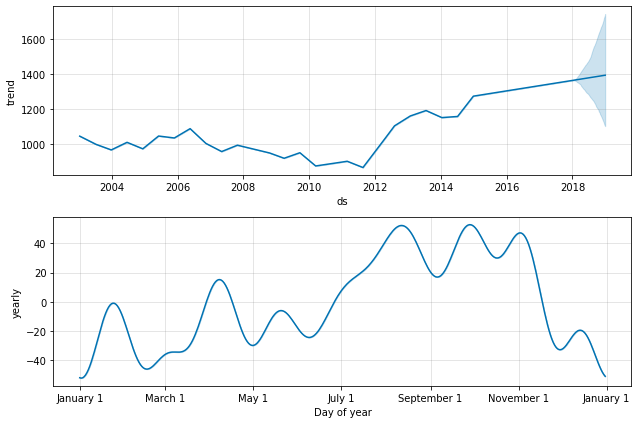

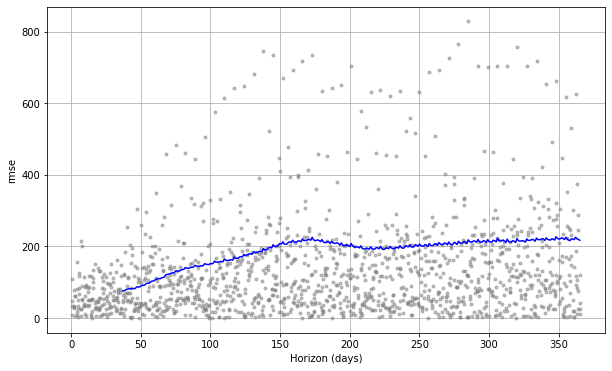

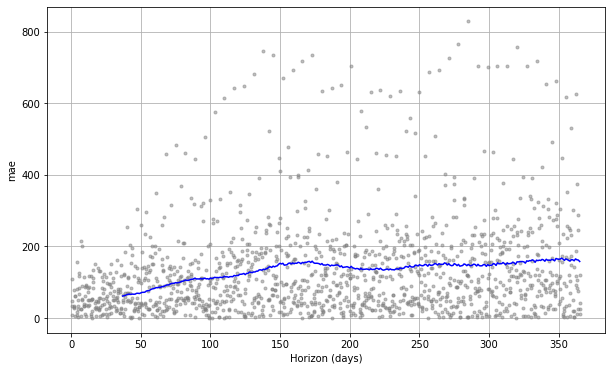

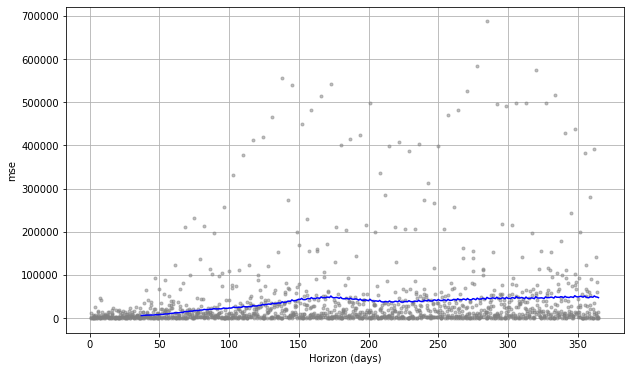

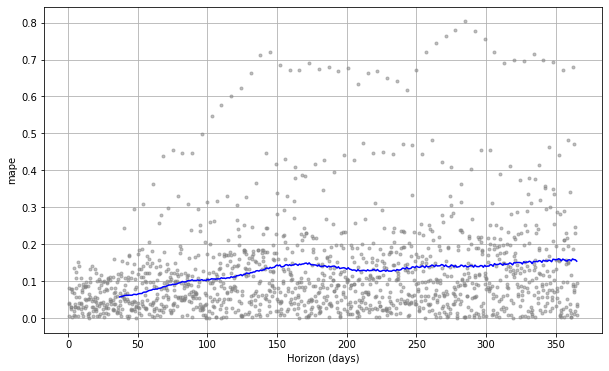

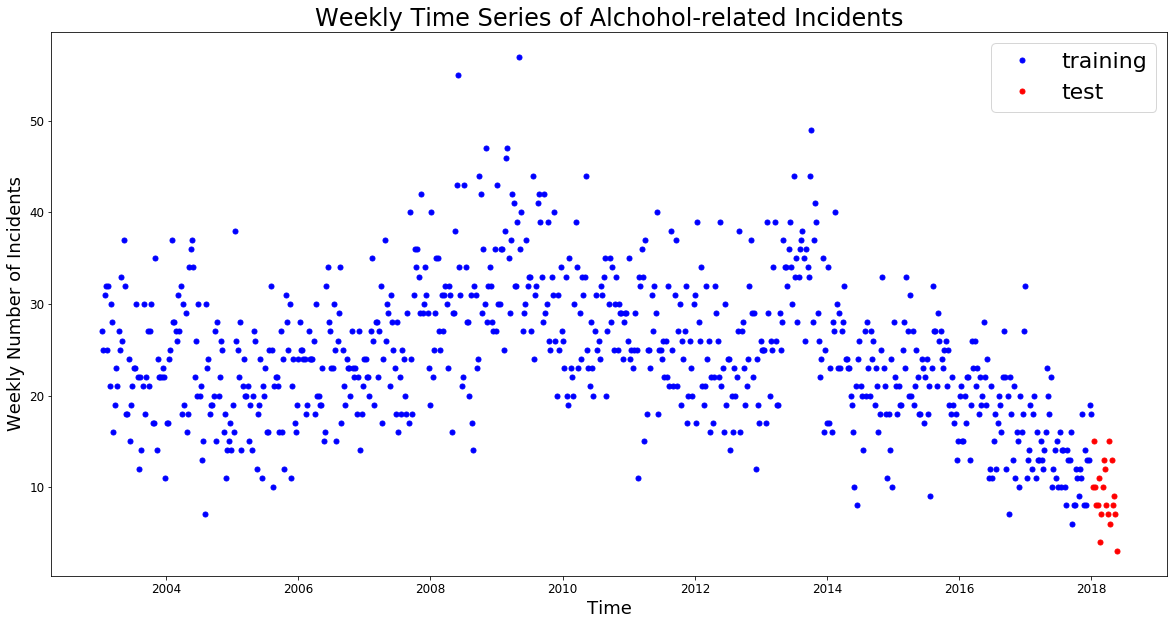

<Figure size 1440x432 with 0 Axes>

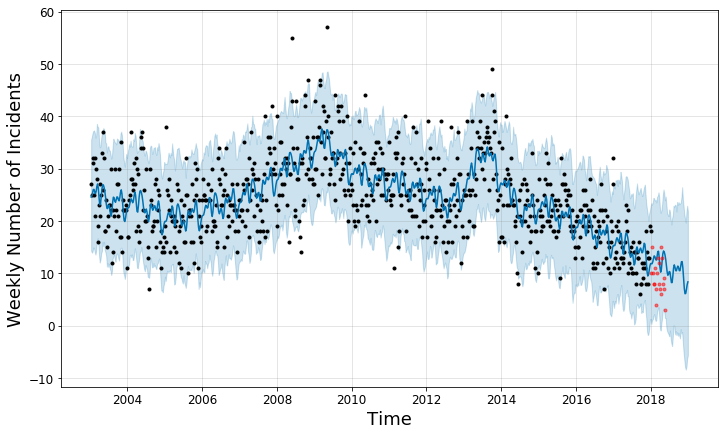

<Figure size 1440x432 with 0 Axes>

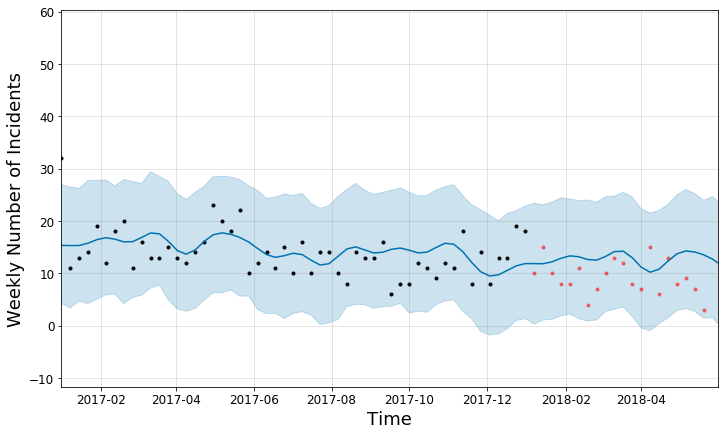

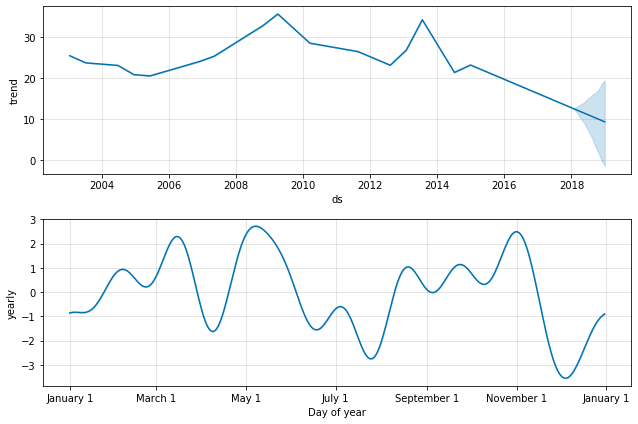

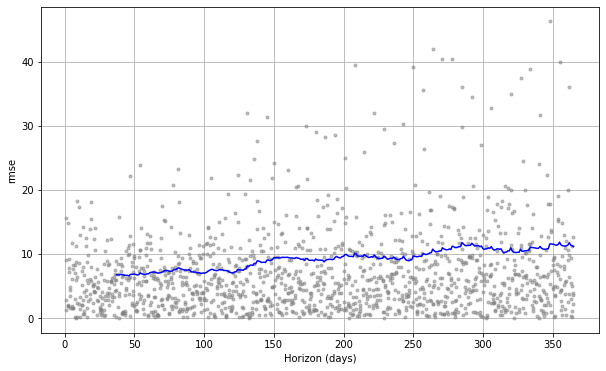

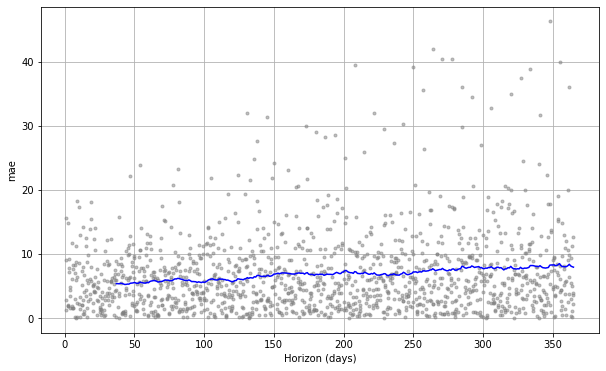

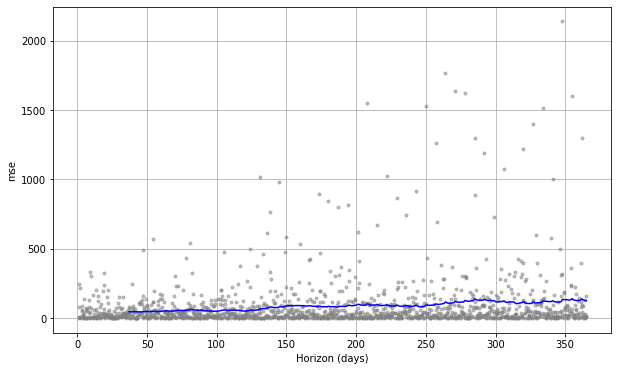

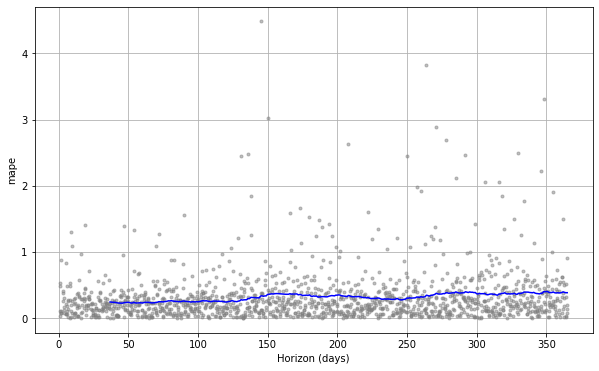

In [8]:
cat_list = unique_incidents['Main_Category'].unique()
# cat_list = ['Drug-related Incidents']

train_start = '2003-01-12'
train_end = '2017-12-31'
test_start = '2018-01-07'
test_end = '2018-12-31'

for cat in cat_list:
    Weekly_Incident_Model (unique_incidents , cat , train_start , train_end , test_start , test_end)